**Name:** Sayed Hesam Alavian \


# Importing the dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from random import shuffle
from copy import deepcopy
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchtext.datasets import YelpReviewPolarity
from torchtext.data.utils import get_tokenizer
import torch.optim as optim
from torchtext.vocab import GloVe, vocab

import re
import nltk
from nltk import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Downloading and preparing dataset

In [3]:
# run this cell to prepare your data


# sample
def sample_k_array(mat, k, labels=2):
  data = []
  for label in range(1, labels + 1):
    temp_mat = mat[mat[:,0] == label]
    temp_array = temp_mat[np.random.choice(temp_mat.shape[0], k, replace=False), :]
    for item in temp_array:
      data.append(item)
  return np.array(data)

# download dataset
YelpReviewPolarity(root='.', split=('train', 'test'))

# reading train & test data
train_dataframe = pd.read_csv('YelpReviewPolarity/yelp_review_polarity_csv/train.csv')
val_dataframe = pd.read_csv('YelpReviewPolarity/yelp_review_polarity_csv/test.csv')

# renaming columns
train_dataframe = train_dataframe.rename(columns={\
    train_dataframe.columns[0]: 'label', train_dataframe.columns[1]: 'text'})

val_dataframe = val_dataframe.rename(columns={\
    val_dataframe.columns[0]: 'label', val_dataframe.columns[1]: 'text'})


train_mat = train_dataframe.values
val_mat = val_dataframe.values
train_data = sample_k_array(train_mat, 5000)
val_data = sample_k_array(val_mat, 1000)
train_data = pd.DataFrame({
    'text': train_data[:, 1],
    'label': train_data[:, 0]
})
val_data = pd.DataFrame({
    'text': val_data[:, 1],
    'label': val_data[:, 0]
})
train_data['label'] -= 1
val_data['label'] -= 1

In [4]:
# download Glove 100-dim vectors
glove_embedding = GloVe(name='6B', dim=100)

In [5]:
train_data

,text,label
0,My first trip to Phoenix I was looking for the...,0
1,Typical American restaurant. Flavorless. Not t...,0
2,WTF is up with their new policy of adding a qu...,0
3,I have never waited so long for a plate of ric...,0
4,I have definitely experienced better. The serv...,0
...,...,...
9995,So it seem as though management is fixing some...,1
9996,"It pains me to do this, but I must deduct one ...",1
9997,I went here with my family last night before t...,1
9998,Fantastic food! My husband and I both ordered ...,1


In [6]:
val_data

,text,label
0,Usually I really like this place and go often ...,0
1,They just broke into my house without any noti...,0
2,Delivery is not very good !! Was late and didn...,0
3,It is clear that this restaurant knows nothing...,0
4,This place is AWESOME! I'd recommend everyone...,0
...,...,...
1995,"First of all, can Yelp afford to give 1/2 star...",1
1996,This is the epitome of cute restaurants. I lov...,1
1997,Fabulous. Very busy and popular place. Why? Be...,1
1998,"I love, love, love this place for some tapas a...",1


In [7]:
# your code

In [8]:
######################## preprocess text ##########
def preprocess():
    global train_data
    global val_data

    def clean_url(text): # Removes urls
        return re.sub(r'http\S+', '', text)

    train_data['clean_txt'] = train_data['text'].apply(clean_url)
    val_data['clean_txt'] = val_data['text'].apply(clean_url)
    
    def clean_non_alpha(text): # Remove bad characters
        return re.sub('[^a-zA-Z]', ' ', text)

    train_data['clean_txt'] = train_data['clean_txt'].apply(clean_non_alpha)
    val_data['clean_txt'] = val_data['clean_txt'].apply(clean_non_alpha)
   
    def clean_lowercase(text):  # Lowercase
        return str(text).lower()

    train_data['clean_txt'] = train_data['clean_txt'].apply(clean_lowercase)
    val_data['clean_txt'] = val_data['clean_txt'].apply(clean_lowercase)

    ############# Tokenization ##############
    train_data['clean_txt'] = train_data['clean_txt'].apply(word_tokenize)
    val_data['clean_txt'] = val_data['clean_txt'].apply(word_tokenize)

    ################## Remove Stopwords ###########
    sw = set(stopwords.words('english'))

    def clean_stopwords(token):
        return [item for item in token if item not in sw]

    train_data['clean_txt'] = train_data['clean_txt'].apply(clean_stopwords)
    val_data['clean_txt'] = val_data['clean_txt'].apply(clean_stopwords)

    ################### Lemmatization ##################
    lemma = WordNetLemmatizer()
    def clean_lemma(token):
        return [lemma.lemmatize(word=w, pos='v') for w in token]

    train_data['clean_txt'] = train_data['clean_txt'].apply(clean_lemma)
    val_data['clean_txt'] = val_data['clean_txt'].apply(clean_lemma)

    #################### Remove Small Words ###################
    def clean_length(token):
        return [i for i in token if len(i)>2]

    train_data['clean_txt'] = train_data['clean_txt'].apply(clean_length)
    val_data['clean_txt'] = val_data['clean_txt'].apply(clean_length)

    ##################### back to Seq ####################
    def convert_to_string(list_of_tokens):
        return ' '.join(list_of_tokens)

    train_data['clean_txt'] = train_data['clean_txt'].apply(convert_to_string)
    val_data['clean_txt'] = val_data['clean_txt'].apply(convert_to_string)

preprocess()

In [9]:
train_data.head()

,text,label,clean_txt
0,My first trip to Phoenix I was looking for the...,0,first trip phoenix look best food donwtown pho...
1,Typical American restaurant. Flavorless. Not t...,0,typical american restaurant flavorless mention...
2,WTF is up with their new policy of adding a qu...,0,wtf new policy add quarter order item never he...
3,I have never waited so long for a plate of ric...,0,never wait long plate rice bowl pho life short...
4,I have definitely experienced better. The serv...,0,definitely experience better service slow real...


In [10]:
val_data.head()

,text,label,clean_txt
0,Usually I really like this place and go often ...,0,usually really like place often rotten experie...
1,They just broke into my house without any noti...,0,break house without notice show around knock v...
2,Delivery is not very good !! Was late and didn...,0,delivery good late bring plastic wear plat eve...
3,It is clear that this restaurant knows nothing...,0,clear restaurant know nothing service young se...
4,This place is AWESOME! I'd recommend everyone...,0,place awesome recommend everyone take manageme...


In [11]:
x_train = train_data['clean_txt'].to_numpy()
y_train = train_data['label'].to_numpy(dtype=np.int32)
x_val = val_data['clean_txt'].to_numpy()
y_val = val_data['label'].to_numpy(dtype=np.int32)

In [12]:
##################### Glove embedding ############
pad_index = 0
unk_index = 1
glove_vectors = glove_embedding
glove_vocab = vocab(glove_embedding.stoi)
glove_vocab.insert_token("<pad>", pad_index)
glove_vocab.insert_token("<unk>", unk_index)
glove_vocab.set_default_index(unk_index)

glove_vectors = glove_vectors.vectors
glove_vectors = torch.cat((torch.zeros(1,glove_vectors.shape[1]),glove_vectors))

In [13]:
####################### Dataloaders ##################
class DataLoader:
    def __init__(self, x, y, vocab, batch_size=32, pad='<pad>', unk='<unk>'):
        self.x = x
        self.y = y
        self.index = 0
        self.batch_size = batch_size
        self.pad = pad
        self.indexes = list(range(len(self.x)))
        shuffle(self.indexes)
        self.vocab = vocab
        
    def get_batch(self):
        if self.index + self.batch_size > len(self.x):
            self.index = 0
            shuffle(self.indexes)

        batch = []
        batch_x = self.x[self.indexes[self.index : self.index + self.batch_size]]
        batch_x_split = [sent.split() for sent in batch_x]
        batch_y = self.y[self.indexes[self.index : self.index + self.batch_size]]

        max_len = max([len(s) for s in batch_x_split])

        padded_batch_x = []
        for i in range(len(batch_x)):
            x = batch_x_split[i]
            padded_x = x + [self.pad] * (max_len - len(x))
            padded_batch_x.append(self.vocab(padded_x))
        
        self.index += self.batch_size
        
        return torch.tensor(padded_batch_x), torch.tensor(batch_y)

# Defining Model

In [14]:
class YelpClassifier(nn.Module):

    def __init__(self, glove_vectors, hidden_size, num_layers):
        super().__init__()
        # your code
        self.emb = torch.nn.Embedding.from_pretrained(glove_vectors, freeze=True)
        self.lstm = nn.LSTM(
            input_size=glove_vectors.shape[1], hidden_size=hidden_size, 
            num_layers=num_layers, batch_first=True, bidirectional=False
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        i = 0.5
        self.fc.weight.data.uniform_(-i, i)
        self.fc.bias.data.zero_()

    def forward(self, x):
        # your code
        a = self.emb(x)
        b, (hn, cn) = self.lstm(a)
        c = b[:, -1, :]
        d = self.fc(c)
        e = torch.squeeze(d, 1)
        OutPut = torch.sigmoid(e)
        return OutPut

# Training & Evaluation

In [15]:
# your code
class TrainLoop:
    def __init__(self, model, data_loader, loss_fn, optimizer):
        self.model = model
        self.data_loader = data_loader
        self.loss_fn = loss_fn 
        self.optimizer = optimizer
        self.loss_hist = []
        self.accuracy_hist = []
        
    def loop(self, n_batches, verbose=True):
        total_loss = 0

        y_pred = torch.tensor([])
        y_true = torch.tensor([])

        for _ in tqdm(range(n_batches)):
            inputs, labels = self.data_loader.get_batch()

            self.optimizer.zero_grad()

            outputs = self.model(inputs)
            
            loss = self.loss_fn(outputs, labels.float())
            loss.requres_grad = True
            loss.backward()

            self.optimizer.step()

            total_loss += loss.item()

            y_pred = torch.cat((y_pred, outputs>.5))
            y_true = torch.cat((y_true, labels))

        avg_batch_loss = total_loss / n_batches
        avg_accuracy = f1_score(y_true, y_pred.detach())

        self.loss_hist.append(avg_batch_loss)
        self.accuracy_hist.append(avg_accuracy)

        if verbose:
            print(f"    Train loss: {avg_batch_loss:.4f}    F1-score: {avg_accuracy:.4f}")

        return avg_batch_loss


class TestLoop:
    def __init__(self, model, data_loader, loss_fn):
        self.model = model
        self.data_loader = data_loader
        self.loss_fn = loss_fn
        self.loss_hist = []
        self.accuracy_hist = []

    def loop(self, n_batches, verbose=True):

        total_loss = 0

        y_pred = torch.tensor([])
        y_true = torch.tensor([])
        
        for _ in range(n_batches):
            inputs, labels = self.data_loader.get_batch()

            with torch.no_grad():
                outputs = self.model(inputs)

            outputs = self.model(inputs)
            
            loss = self.loss_fn(outputs, labels.float())

            total_loss += loss
        
            y_pred = torch.cat((y_pred, outputs>.5))
            y_true = torch.cat((y_true, labels))

        avg_batch_loss = total_loss / n_batches
        avg_accuracy = f1_score(y_true, y_pred.detach())

        self.loss_hist.append(avg_batch_loss)
        self.accuracy_hist.append(avg_accuracy)

        if verbose:
            print(f"    Validation loss:  {avg_batch_loss:.4f}    F1-score: {avg_accuracy:.4f}")

        return avg_batch_loss, avg_accuracy

In [16]:
# train_size = x_train.shape[0]
# val_size = x_val.shape[0]
# batch_size = 16

# epochs = 30
# model = YelpClassifier(glove_vectors, hidden_size=16, num_layers=1)
# model_best = None

# loss_fn = nn.BCELoss()
# learning_rate = 0.001
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loader_train = DataLoader(x_train, y_train, vocab=glove_vocab, batch_size=batch_size)
# loader_test = DataLoader(x_val, y_val, vocab=glove_vocab, batch_size=batch_size)

# train_looper = TrainLoop(model, loader_train, loss_fn, optimizer)
# test_looper = TestLoop(model, loader_test, loss_fn)

# best_loss = 0
# for epoch in tqdm(range(epochs)):
#     print(f" Epoch {epoch+1} ".center(50, '='))
#     train_looper.loop(n_batches=128)
#     loss, _ = test_looper.loop(n_batches=16)
#     if loss < best_loss:
#         best_loss = loss
#         model_best = deepcopy(model)


# Draw Loss & F1-score

In [17]:
# fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# axs[0].plot(train_looper.loss_hist, label="train", color='r')
# axs[0].plot(test_looper.loss_hist, label="validation", color='b')
# axs[0].set_title("Loss")
# axs[0].legend()

# axs[1].plot(train_looper.accuracy_hist, label="train", color='r')
# axs[1].plot(test_looper.accuracy_hist, label="validation", color='b')
# axs[1].set_title("F1-score")
# axs[1].legend()

In [18]:
# train_loss_hist = []
# for item in train_looper.loss_hist:
#     if len(train_loss_hist) == 0 or item < train_loss_hist[-1]:
#         train_loss_hist.append(item)
#     else:
#         train_loss_hist.append(train_loss_hist[-1])

# test_loss_hist = []
# for item in test_looper.loss_hist:
#     if len(test_loss_hist) == 0 or item < test_loss_hist[-1]:
#         test_loss_hist.append(item)
#     else:
#         test_loss_hist.append(test_loss_hist[-1])

# train_accuracy_hist = []
# for item in train_looper.accuracy_hist:
#     if len(train_accuracy_hist) == 0 or item > train_accuracy_hist[-1]:
#         train_accuracy_hist.append(item)
#     else:
#         train_accuracy_hist.append(train_accuracy_hist[-1])

# test_accuracy_hist = []
# for item in test_looper.accuracy_hist:
#     if len(test_accuracy_hist) == 0 or item > test_accuracy_hist[-1]:
#         test_accuracy_hist.append(item)
#     else:
#         test_accuracy_hist.append(test_accuracy_hist[-1])

# fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# axs[0].plot(train_loss_hist, label="train", color='r')
# axs[0].plot(test_loss_hist, label="validation", color='b')
# axs[0].set_title("Loss (keeping best model)")
# axs[0].legend()

# axs[1].plot(train_accuracy_hist, label="train", color='r')
# axs[1].plot(test_accuracy_hist, label="validation", color='b')
# axs[1].set_title("F1-score (keeping best model)")
# axs[1].legend()


#BiLSTM

In [19]:
class YelpClassifierBiLSTM(nn.Module):

    def __init__(self, glove_vectors, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = torch.nn.Embedding.from_pretrained(glove_vectors, freeze=True)
        self.lstm = nn.LSTM(
            input_size=glove_vectors.shape[1], hidden_size=hidden_size, 
            num_layers=num_layers, batch_first=True, bidirectional=True
        )
        self.drop = nn.Dropout(p=0.5)
        self.fc = nn.Linear(2*hidden_size, 1)
        self.init_weights()

    def init_weights(self):
        i = 0.5
        self.fc.weight.data.uniform_(-i, i)
        self.fc.bias.data.zero_()

    def forward(self, x):

        a = self.emb(x)      
        b, (hn, cn) = self.lstm(a)
  
        out_forward = b[range(len(b)), b.shape[1]-1, :self.hidden_size]
        out_backward = b[:, 0, self.hidden_size:]
        out_cat = torch.cat((out_forward, out_backward), 1)
        out_lstm = self.drop(out_cat)
        
        d = self.fc(out_lstm)
        e = torch.squeeze(d, 1)
        OutPut = torch.sigmoid(e)

        return OutPut

In [21]:
train_size = x_train.shape[0]
val_size = x_val.shape[0]
batch_size = 16

epochs = 30
model_BiLSTM = YelpClassifierBiLSTM(glove_vectors, hidden_size=64, num_layers=1)
model_best_BiLSTM = None

loss_fn = nn.BCELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model_BiLSTM.parameters(), lr=learning_rate)

loader_train = DataLoader(x_train, y_train, vocab=glove_vocab, batch_size=batch_size)
loader_test = DataLoader(x_val, y_val, vocab=glove_vocab, batch_size=batch_size)

train_looper = TrainLoop(model_BiLSTM, loader_train, loss_fn, optimizer)
test_looper = TestLoop(model_BiLSTM, loader_test, loss_fn)

best_loss = 0
for epoch in tqdm(range(epochs)):
    print(f" Epoch {epoch+1} ".center(50, '='))
    train_looper.loop(n_batches=128)
    loss, _ = test_looper.loop(n_batches=16)
    if loss < best_loss:
        best_loss = loss
        model_best_BiLSTM = deepcopy(model_BiLSTM)

  0%|          | 0/30 [00:00<?, ?it/s]

==================== Epoch 1 =====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.6593    F1-score: 0.6157
    Validation loss:  0.6049    F1-score: 0.6588
==================== Epoch 2 =====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.5644    F1-score: 0.7105
    Validation loss:  0.5749    F1-score: 0.7133
==================== Epoch 3 =====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.5390    F1-score: 0.7226
    Validation loss:  0.5901    F1-score: 0.7172
==================== Epoch 4 =====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.4738    F1-score: 0.7964
    Validation loss:  0.4648    F1-score: 0.7203
==================== Epoch 5 =====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.4936    F1-score: 0.7820
    Validation loss:  0.4191    F1-score: 0.7939
==================== Epoch 6 =====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.4268    F1-score: 0.8265
    Validation loss:  0.4233    F1-score: 0.8211
==================== Epoch 7 =====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.4219    F1-score: 0.8018
    Validation loss:  0.4816    F1-score: 0.7770
==================== Epoch 8 =====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.4233    F1-score: 0.8185
    Validation loss:  0.3382    F1-score: 0.8550
==================== Epoch 9 =====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.4000    F1-score: 0.8312
    Validation loss:  0.3995    F1-score: 0.8315
==================== Epoch 10 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.3571    F1-score: 0.8631
    Validation loss:  0.3746    F1-score: 0.8507
==================== Epoch 11 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.3873    F1-score: 0.8387
    Validation loss:  0.4234    F1-score: 0.8286
==================== Epoch 12 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.3970    F1-score: 0.8184
    Validation loss:  0.3812    F1-score: 0.8429
==================== Epoch 13 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.3497    F1-score: 0.8542
    Validation loss:  0.3378    F1-score: 0.8546
==================== Epoch 14 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.3345    F1-score: 0.8589
    Validation loss:  0.3022    F1-score: 0.8943
==================== Epoch 15 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.3253    F1-score: 0.8658
    Validation loss:  0.3874    F1-score: 0.8333
==================== Epoch 16 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.3278    F1-score: 0.8678
    Validation loss:  0.4242    F1-score: 0.8291
==================== Epoch 17 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.3048    F1-score: 0.8713
    Validation loss:  0.3435    F1-score: 0.8608
==================== Epoch 18 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.3027    F1-score: 0.8758
    Validation loss:  0.3289    F1-score: 0.8750
==================== Epoch 19 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.3329    F1-score: 0.8626
    Validation loss:  0.3431    F1-score: 0.8920
==================== Epoch 20 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.2824    F1-score: 0.8825
    Validation loss:  0.3446    F1-score: 0.8593
==================== Epoch 21 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.4420    F1-score: 0.7976
    Validation loss:  0.4323    F1-score: 0.8300
==================== Epoch 22 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.3224    F1-score: 0.8519
    Validation loss:  0.3700    F1-score: 0.8602
==================== Epoch 23 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.3217    F1-score: 0.8640
    Validation loss:  0.3244    F1-score: 0.8155
==================== Epoch 24 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.2917    F1-score: 0.8866
    Validation loss:  0.3065    F1-score: 0.8689
==================== Epoch 25 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.2988    F1-score: 0.8860
    Validation loss:  0.3503    F1-score: 0.8727
==================== Epoch 26 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.2872    F1-score: 0.8871
    Validation loss:  0.3864    F1-score: 0.8249
==================== Epoch 27 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.2876    F1-score: 0.8936
    Validation loss:  0.3051    F1-score: 0.8914
==================== Epoch 28 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.2659    F1-score: 0.8957
    Validation loss:  0.2588    F1-score: 0.8803
==================== Epoch 29 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.2753    F1-score: 0.8844
    Validation loss:  0.3271    F1-score: 0.8514
==================== Epoch 30 ====================


  0%|          | 0/128 [00:00<?, ?it/s]

    Train loss: 0.2517    F1-score: 0.9068
    Validation loss:  0.3320    F1-score: 0.8455


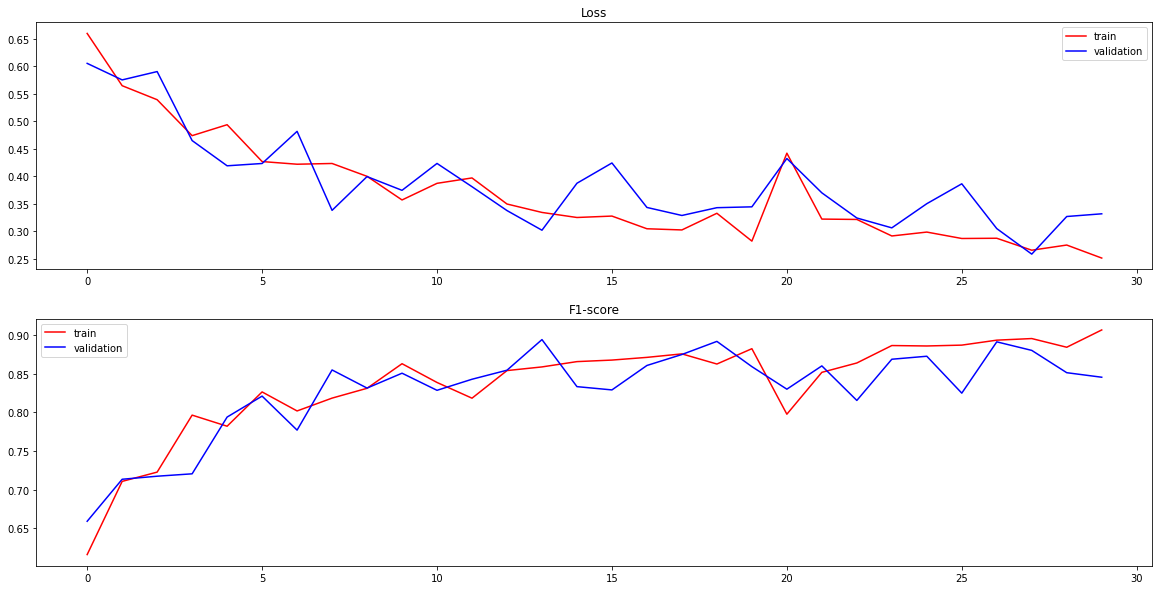

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))

axs[0].plot(train_looper.loss_hist, label="train", color='r')
axs[0].plot(test_looper.loss_hist, label="validation", color='b')
axs[0].set_title("Loss")
axs[0].legend()

axs[1].plot(train_looper.accuracy_hist, label="train", color='r')
axs[1].plot(test_looper.accuracy_hist, label="validation", color='b')
axs[1].set_title("F1-score")
axs[1].legend()

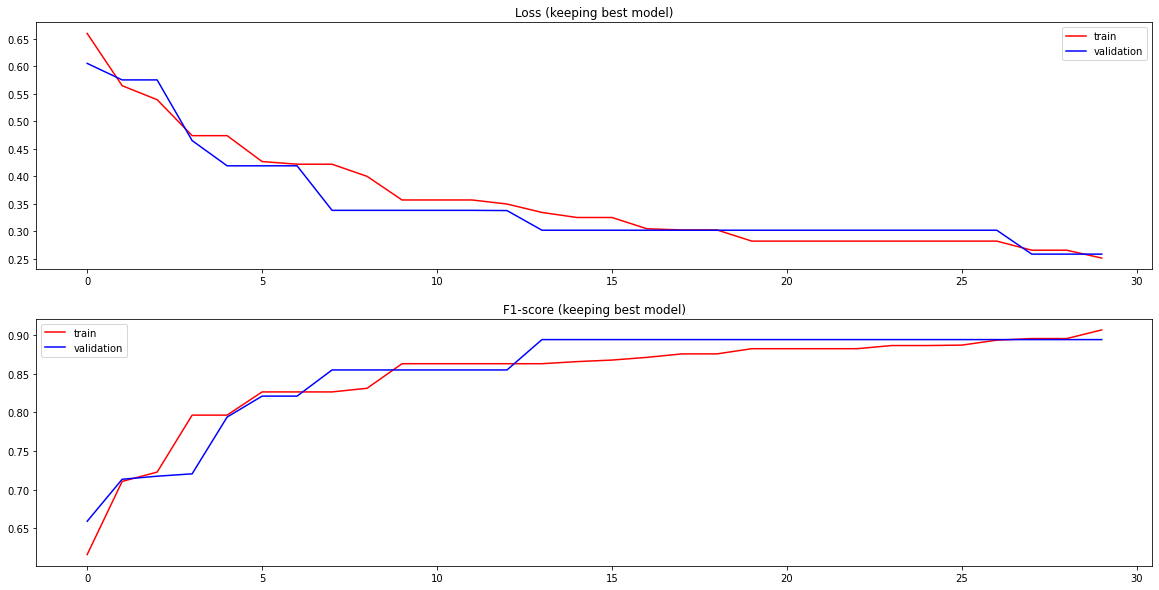

In [23]:
train_loss_hist = []
for item in train_looper.loss_hist:
    if len(train_loss_hist) == 0 or item < train_loss_hist[-1]:
        train_loss_hist.append(item)
    else:
        train_loss_hist.append(train_loss_hist[-1])

test_loss_hist = []
for item in test_looper.loss_hist:
    if len(test_loss_hist) == 0 or item < test_loss_hist[-1]:
        test_loss_hist.append(item)
    else:
        test_loss_hist.append(test_loss_hist[-1])

train_accuracy_hist = []
for item in train_looper.accuracy_hist:
    if len(train_accuracy_hist) == 0 or item > train_accuracy_hist[-1]:
        train_accuracy_hist.append(item)
    else:
        train_accuracy_hist.append(train_accuracy_hist[-1])

test_accuracy_hist = []
for item in test_looper.accuracy_hist:
    if len(test_accuracy_hist) == 0 or item > test_accuracy_hist[-1]:
        test_accuracy_hist.append(item)
    else:
        test_accuracy_hist.append(test_accuracy_hist[-1])

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

axs[0].plot(train_loss_hist, label="train", color='r')
axs[0].plot(test_loss_hist, label="validation", color='b')
axs[0].set_title("Loss (keeping best model)")
axs[0].legend()

axs[1].plot(train_accuracy_hist, label="train", color='r')
axs[1].plot(test_accuracy_hist, label="validation", color='b')
axs[1].set_title("F1-score (keeping best model)")
axs[1].legend()